In [ ]:
# Standard Libraries
import gc
import os
import numpy as np
from matplotlib import pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer
from tensorflow.keras.models import Sequential, Model

from skimage.color import rgb2lab, lab2rgb, rgb2gray

import kagglehub

In [ ]:
dataset_path = kagglehub.dataset_download('aayush9753/image-colorization-dataset')

In [13]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Define a random seed for reproducibility
random_seed = 10

# Load the dataset from the specified directory
dataset_directory = dataset_path + '/data'

# Configure the dataset for training with specific size of 256x256
dataset_images = image_data_generator.flow_from_directory(
    dataset_directory,
    target_size=(256, 256),
    seed=random_seed,
    batch_size=64,
)

#Considering 4500 Training Images and 500 Testing Images
train_color, test_color = [],[]
train_num, test_num = 4500,500
for iter, batch in enumerate(dataset_images):
    #Break condition - if we reach desired amount of images then we stop the loop
    if len(train_color) >= train_num and len(test_color) >= test_num:
        break
    #Considering test image from the directory
    color_img_batch_test = batch[0][np.argmax(batch[1], axis=1) == 1]
    #Considering train image from the directory
    color_img_batch_train = batch[0][np.argmax(batch[1], axis=1) == 3]

    #Appending to respective arrays
    if len(test_color) < test_num:
        for img in color_img_batch_test:
            test_color.append(img)

    if len(train_color) < train_num:
        for img in color_img_batch_train:
            train_color.append(img)

    if iter % 10==0:
        print(f'Batch Completed : {iter}')

print("Training size : "+np.array(train_color)[:train_num].shape)
print("Testing size : "+np.array(test_color)[:test_num].shape)

Found 11478 images belonging to 4 classes.
Batch Completed : 10
Batch Completed : 20
Batch Completed : 30
Batch Completed : 40
Batch Completed : 50
Batch Completed : 60
Batch Completed : 70
Batch Completed : 80
Batch Completed : 90
Batch Completed : 100
Training size : (4500, 256, 256, 3)
Testing size : (500, 256, 256, 3)


In [12]:
import numpy as np
from skimage.color import rgb2lab, lab2rgb

#Function to Colorizes grayscale images using a trained autoencoder model.
def colorize_image(autoencoder, X):
    # Predict the AB channels using the autoencoder
    Y_pred = autoencoder.predict(X)

    # Rescale the predicted AB channels from [-1, 1] to [-128, 128]
    Y_pred = Y_pred * 128

    # Initialize an array to hold the final colorized RGB images
    num_images = X.shape[0]
    colorized_images = np.zeros((num_images, 256, 256, 3))

    for i in range(num_images):
        # Extract and rescale the L channel from [-1, 1] to [0, 100]
        l_channel = X[i][:, :, 0] * 50 + 50

        # Combine the L and AB channels into a single LAB image
        lab_image = np.concatenate((l_channel[:, :, np.newaxis], Y_pred[i]), axis=2)

        # Convert the LAB image to RGB
        colorized_images[i] = lab2rgb(lab_image)

    return colorized_images

#Function Preprocesses images by converting them to LAB color space and normalizing the channels.
def preprocess(images):
    # Convert the images from RGB to LAB color space
    images_lab = [rgb2lab(image) for image in images]
    images_lab = np.array(images_lab)

    # Extract the L channel and AB channels
    L_channel = images_lab[:, :, :, 0]
    AB_channels = images_lab[:, :, :, 1:]

    # Normalize the L channel from [0, 100] to [-1, 1]
    X = L_channel / 50 - 1

    # Normalize the AB channels from [-128, 128] to [-1, 1]
    Y = AB_channels / 128

    # Add a channel dimension to X for compatibility with the model
    X = X[..., np.newaxis]

    return X, Y


In [11]:
#Preprocesssing the training and testing sets
X_train, Y_train = preprocess(train_color)
X_test, Y_test = preprocess(test_color)

In [13]:
#Autoencoder Class
class Autoencoder:
    def __init__(self, input_shape=(256, 256, 1)):
        self.input_shape = input_shape
        #Calling Generate Encoder function
        self.encoder = self.generate_encoder()
        #Calling Generate Decoder function
        self.decoder = self.generate_decoder()
        self.autoencoder = self.build_autoencoder()

    # Adding multiple Conv2D layers with increasing filters to learn features hierarchically
    def generate_encoder(self):
        model = Sequential()
        model.add(InputLayer(input_shape=self.input_shape))
        #Convolution Layers with increasing filters
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        return model
    
    # Addding Conv2D layers with decreasing filters to reconstruct spatial dimensions and features as part of decoding
    def generate_decoder(self):
        model = Sequential()
        #Convolution Layers with decreasing filters
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(4, (3, 3), activation='tanh', padding='same'))
        model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
        model.add(UpSampling2D((2, 2)))
        return model

    def build_autoencoder(self):
        # Combining the encoder and decoder to create complete autoencoder model
        inputs = tf.keras.Input(shape=self.input_shape)
        x = self.encoder(inputs)
        outputs = self.decoder(x)
        return Model(inputs=inputs, outputs=outputs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [14]:
#Intialize the autoencoder
autoencoder = Autoencoder().autoencoder
#Set Optimizer as Adam and Loss function as Mean Squared Error
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss='mse')

#Training the autoencoder model using the fit method
#We used a batch size of 32 indicating Number of samples per training batch and 32 epochs indicating number of complete passed through the trianing dataset
history = autoencoder.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test), # Validation data to monitor performance during training
    batch_size = 32,
    epochs=32
)

Epoch 1/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 163s 859ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 2/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 92s 355ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 3/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 346ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 4/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 356ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 5/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 49s 346ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 6/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 355ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 7/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 352ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 8/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 354ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 9/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 353ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 10/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 354ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 11/32
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 352ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 12/32
141/14

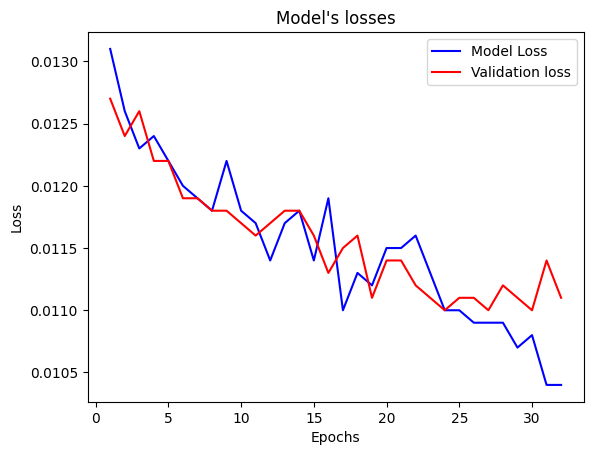

In [14]:
#Since Colorization of Image is Unsuperized task, we don't have an accuracy metric, instead we use the loss metric to understand how the model has performed
#Plotting the Losses of Model 
model_loss =  history.history.get('loss')
validation_loss = history.history.get('val_loss')

plt.figure(figsize=(8, 5))

plt.title('Model\'s losses')
plt.plot(model_loss, color="blue")
plt.plot(validation_loss, color="red")
plt.legend(['Loss', 'Validation Loss'])
plt.show()

In [16]:
# Performing prediction on test data set
Y_Pred = colorize_image(autoencoder, X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 29 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 56 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative 

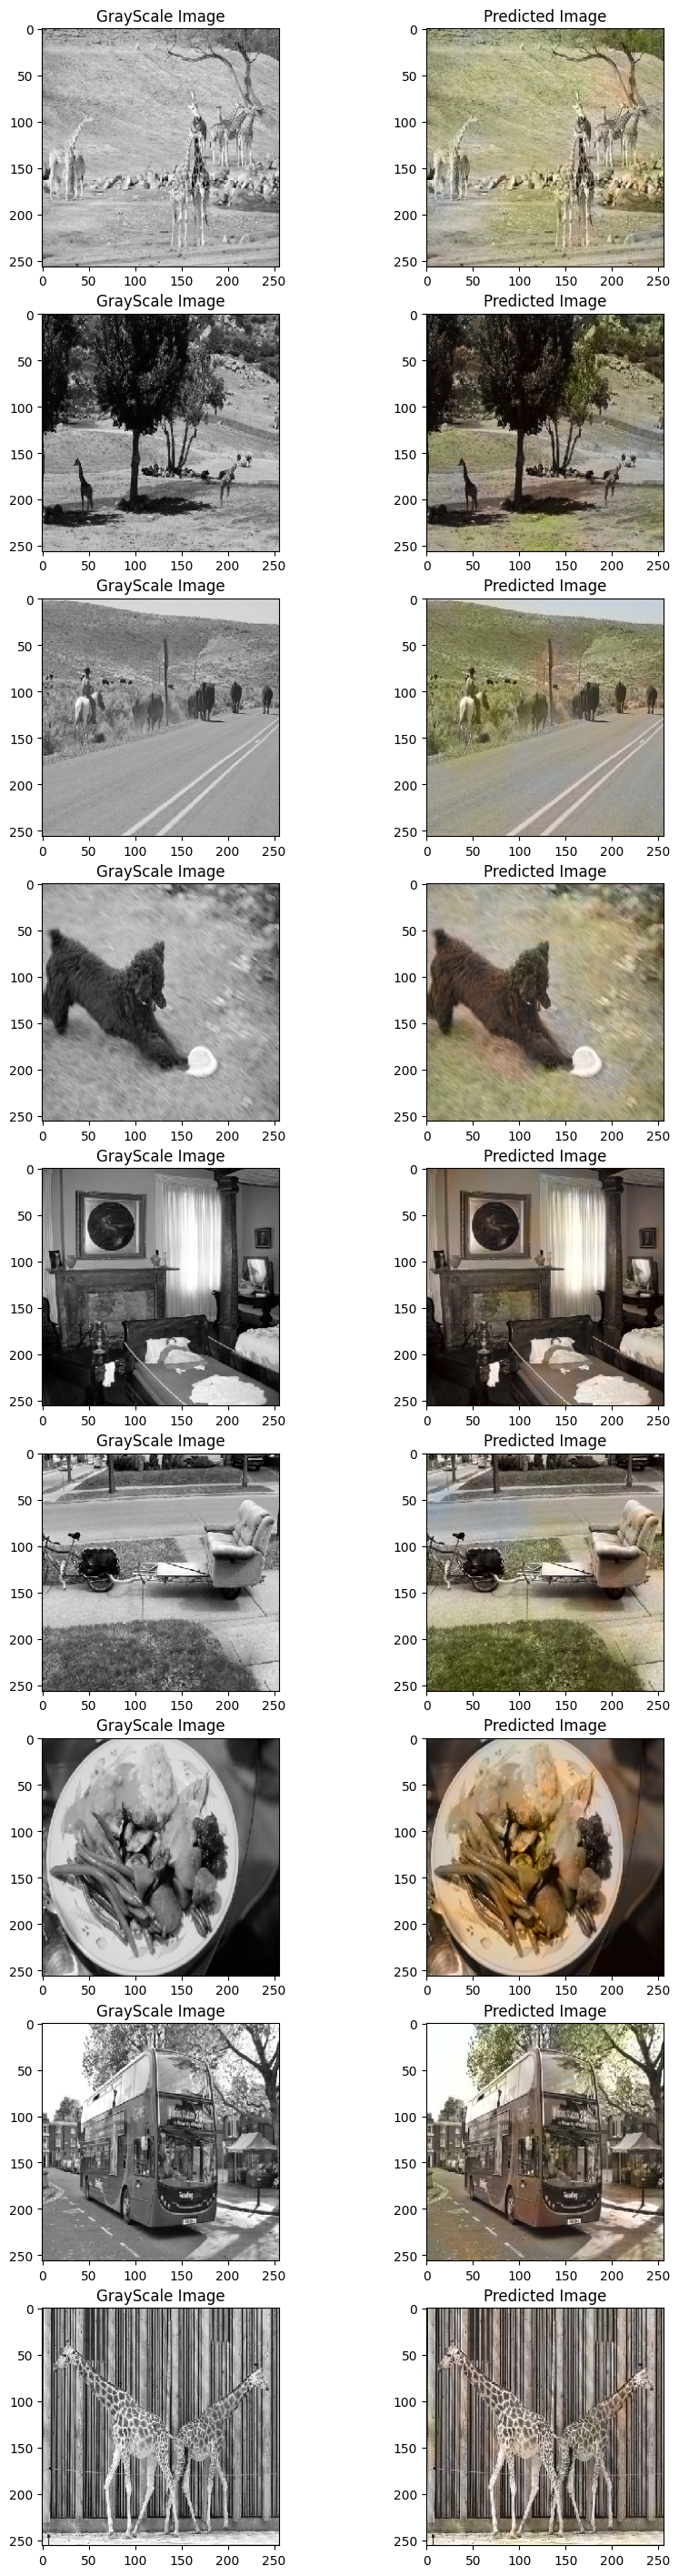

In [28]:
#Vizualizing the predictions performed by model
plt.figure(figsize=(10, 40))
s, e = 23, 32
index = 1
for i, j in zip(X_test[s:e], Y_Pred[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i, cmap='gray')
    plt.title('GrayScale Image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j)
    plt.title('Predicted Image')
    index += 2

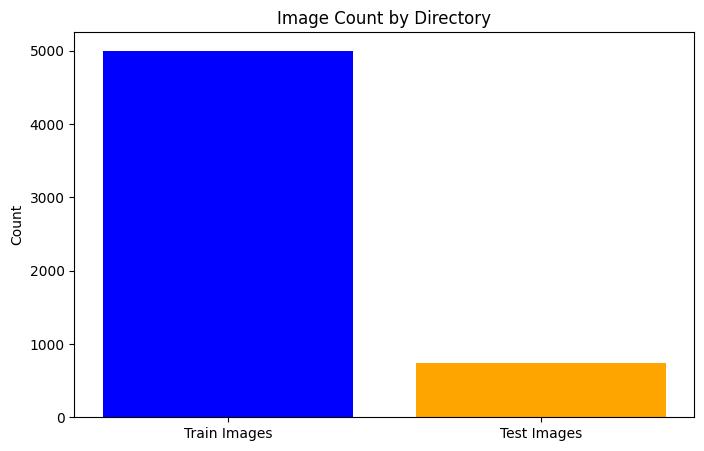

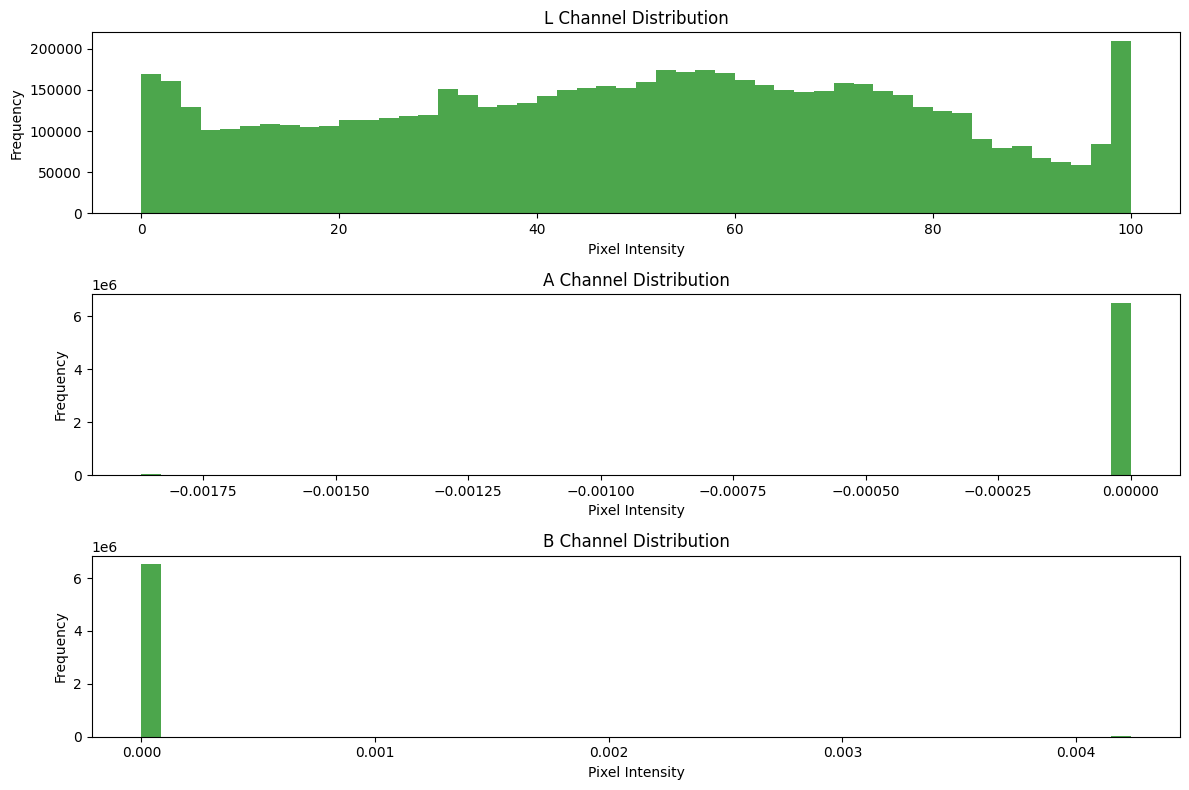

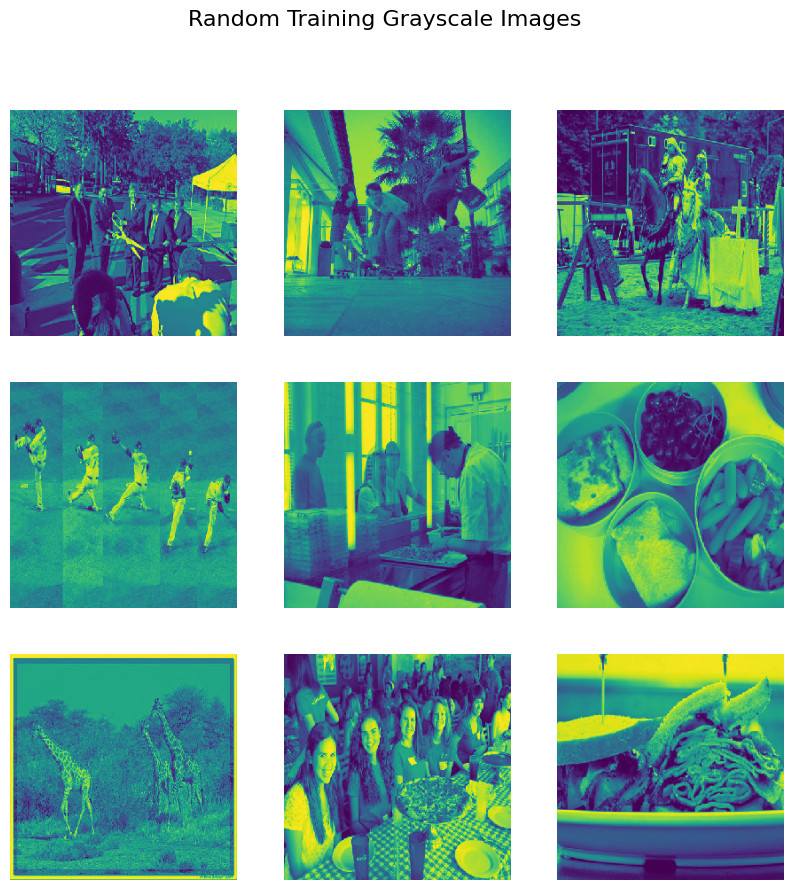

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 73 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])
<ipython-input-10-d41d7b31ff91>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8 negative Z values that have been clipped to zero
  colorized_images[i] = lab2rgb(colorized_images[i])


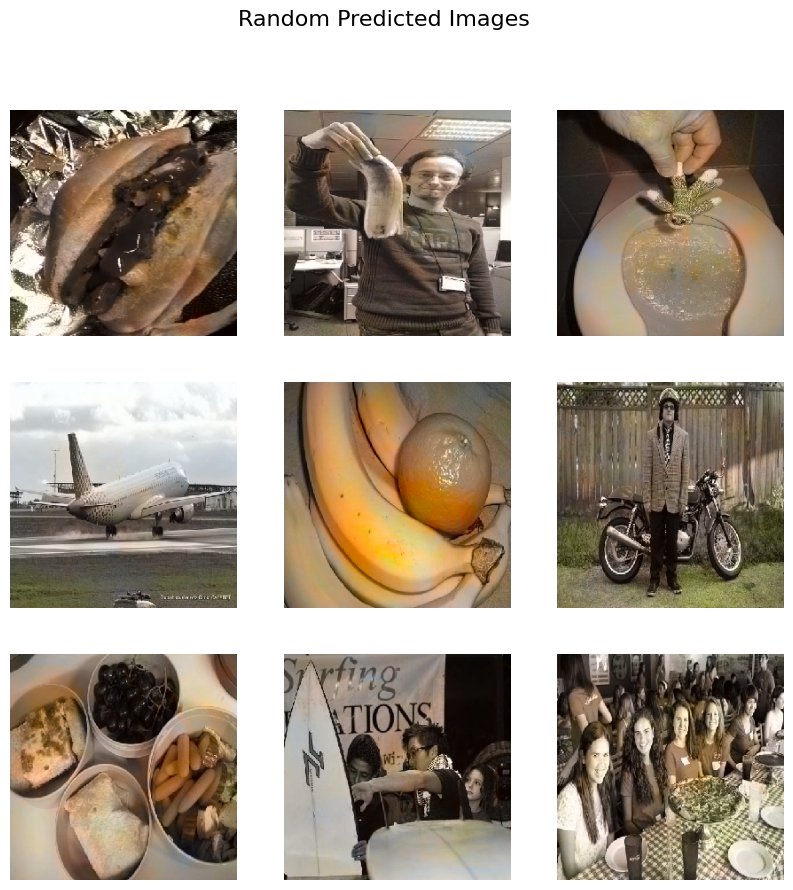

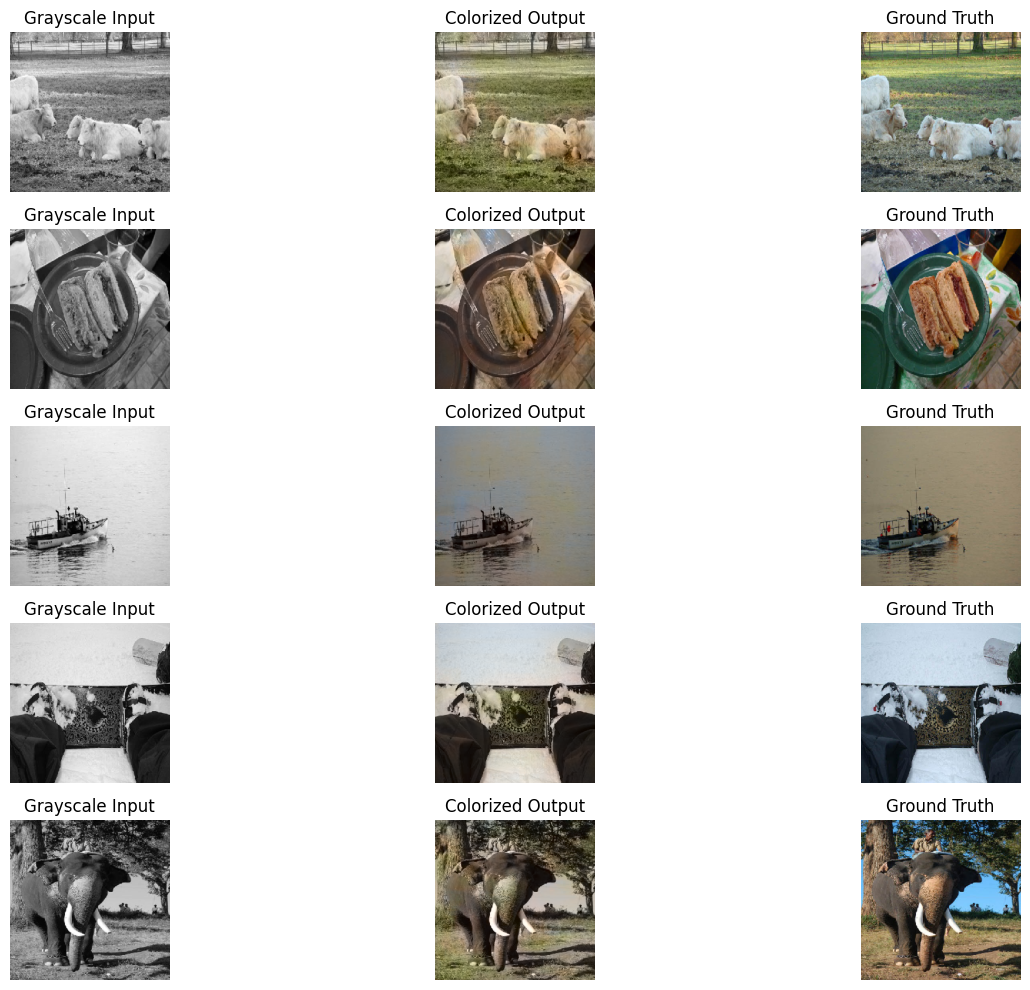

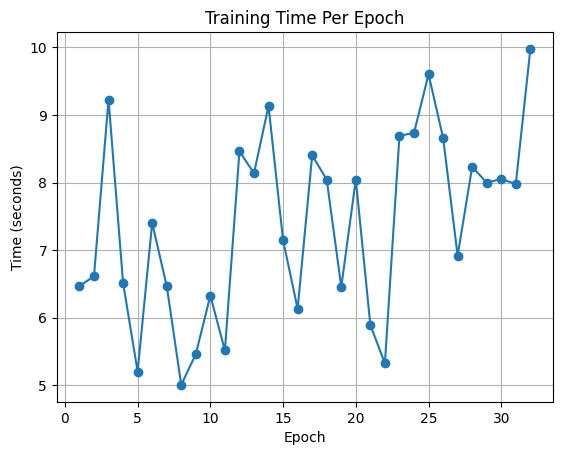

In [29]:
# Plotting Data for Analysis
train_dir = os.path.join(dataset_path, 'data/train_color')
test_dir = os.path.join(dataset_path, 'data/test_color')

# 1. Image Count by Directory (Training and Test sets)
train_count = len(os.listdir(train_dir))
test_count = len(os.listdir(test_dir))

plt.figure(figsize=(8, 5))
plt.bar(['Train Images', 'Test Images'], [train_count, test_count], color=['blue', 'orange'])
plt.title('Image Count by Directory')
plt.ylabel('Count')
plt.show()

# 2. Color Distribution: Histograms of L, A, B channels
rgb_train_images = [lab2rgb(np.concatenate((img * 50 + 50, np.zeros((256, 256, 2))), axis=-1)) for img in X_train[:100]]
lab_train_images = [rgb2lab(img) for img in rgb_train_images]  # Use a subset for efficiency
lab_train_images = np.array(lab_train_images)

plt.figure(figsize=(12, 8))
for i, channel in enumerate(['L', 'A', 'B']):
    plt.subplot(3, 1, i+1)
    plt.hist(lab_train_images[..., i].flatten(), bins=50, color='green', alpha=0.7)
    plt.title(f'{channel} Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Random Image Examples: Display random images from training set
def plot_random_images(images, title):
    indices = random.sample(range(len(images)), 9)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[idx])
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Random images from train and test sets
plot_random_images(X_train.squeeze(), 'Random Training Grayscale Images')
plot_random_images(colorize_image(autoencoder, X_train[:100]), 'Random Predicted Images')

# 4. Prediction Comparison (Grayscale, Prediction, Ground Truth)
plt.figure(figsize=(15, 10))
n_samples = 5  # Number of samples to compare

for i in range(n_samples):
    plt.subplot(n_samples, 3, i*3 + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')

    plt.subplot(n_samples, 3, i*3 + 2)
    plt.imshow(Y_Pred[i])
    plt.title('Colorized Output')
    plt.axis('off')

    plt.subplot(n_samples, 3, i*3 + 3)
    plt.imshow(lab2rgb(np.concatenate((X_test[i] * 50 + 50, Y_test[i] * 128), axis=-1)))
    plt.title('Ground Truth')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 5. Training Time Per Epoch (Generate Dummy Training Times for Illustration)
epochs = range(1, len(model_loss) + 1)
train_times = np.random.uniform(5, 10, len(model_loss))  # Replace with actual times if logged

plt.plot(epochs, train_times, marker='o')
plt.title('Training Time Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()



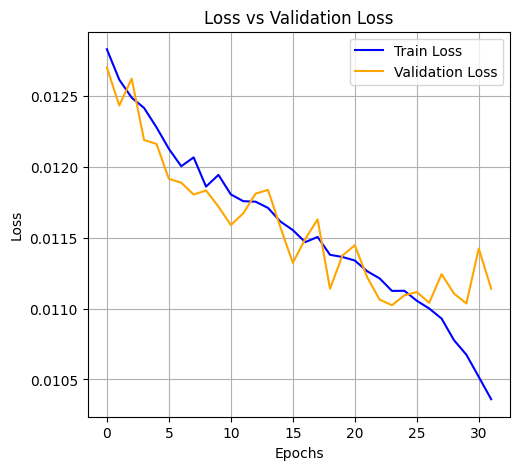

In [30]:
# Extract history data
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
mse = history.history.get('mse')
val_mse = history.history.get('mse')

# Plot Loss vs Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
